In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

import IPython
import IPython.display

import tensorflow as tf
from keras.layers import Dense, LSTM


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# sklearn config
from sklearn import set_config
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer

# IMPORT DATA

In [25]:
local_path = "data\MWG-20230414-1418.csv"
foreign_path = "data\MWG-20230414ndtnn.csv"

In [26]:
header_local = ['date', 'KLGD', 'GTGD', 'capital', 'close_price', 'daily_return','daily_return_pct', 'KL', 'GT']
column_range = list(range(9))
df_local = pd.read_csv(local_path, skiprows= 8 ,index_col=0, header= None, usecols=column_range).reset_index() # Data for local invest
df_local.columns = header_local
print(f"Dữ liệu bao gồm {df_local.shape[0]} dòng và {df_local.shape[1]} cột:")
print ('Mẫu bảng dữ liệu :\n')
df_local.head()

Dữ liệu bao gồm 252 dòng và 9 cột:
Mẫu bảng dữ liệu :



,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT
0,14/04/2023,"1,710,500","69,878","59,633","40,750",-300,-0.73,"1,710,500","69,878"
1,13/04/2023,"3,716,000","153,698","60,072","41,050",300,0.74,"3,135,000","128,411"
2,12/04/2023,"5,666,500","236,849","59,633","40,750",50,0.12,"3,970,800","163,086"
3,11/04/2023,"5,749,500","242,682","59,559","40,700",-300,-0.73,"2,852,300","115,640"
4,10/04/2023,"10,616,296","436,606","59,998","41,000","2,000",5.13,"5,829,400","236,992"


In [27]:
header_foreign = ['date', 'room', 'remain_room_stk','remain_room_pct','kl_buy','kl_buy_pct', 'gt_buy','gt_buy_pct','kl_sell','kl_sell_pct', 'gt_sell','gt_sell_pct','KL_foreign_diff','GT_foreign_diff', 'AT_KL_1', 'AT_KL_1_pct', 'AT_KL_2', 'AT_KL_2_pct']
column_range = list(range(18))
df_foreign = pd.read_csv(foreign_path, skiprows= 8 ,index_col=0, header= None, usecols=column_range).reset_index() # Data for foreign invest
df_foreign.columns = header_foreign
print(f"Dữ liệu bao gồm {df_foreign.shape[0]} dòng và {df_foreign.shape[1]} cột:")
print ('Mẫu bảng dữ liệu :\n')
df_foreign.head()

Dữ liệu bao gồm 252 dòng và 18 cột:
Mẫu bảng dữ liệu :



,date,room,remain_room_stk,remain_room_pct,kl_buy,kl_buy_pct,gt_buy,gt_buy_pct,kl_sell,kl_sell_pct,gt_sell,gt_sell_pct,KL_foreign_diff,GT_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2,AT_KL_2_pct
0,14/04/2023,"717,300,847",72,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,-,NaN,-,NaN
1,13/04/2023,"717,300,847",72,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"581,000",100,"25,286,500,000",100
2,12/04/2023,"717,300,847",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"1,695,700",100,"73,762,950,000",100
3,11/04/2023,"717,300,847",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"2,897,200",100,"127,042,220,000",100
4,10/04/2023,"717,300,847",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"5,403,900",112.89,"225,342,630,000",112.89


In [28]:
foreign_main_cols = header_foreign[3:]
print(foreign_main_cols)

['remain_room_pct', 'kl_buy', 'kl_buy_pct', 'gt_buy', 'gt_buy_pct', 'kl_sell', 'kl_sell_pct', 'gt_sell', 'gt_sell_pct', 'KL_foreign_diff', 'GT_foreign_diff', 'AT_KL_1', 'AT_KL_1_pct', 'AT_KL_2', 'AT_KL_2_pct']


# PREPROCESSING

In [29]:
# Convert the date column to a pandas datetime object
df_local['date'] = pd.to_datetime(df_local['date'], dayfirst=True)
df_local = df_local.sort_values(by='date', ascending=True, ignore_index = True)
df_local.head()

,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT
0,2022-04-14,"2,992,800","477,771","116,758","159,500","3,300",2.11,"2,925,900","467,335"
1,2022-04-15,"2,959,800","480,101","117,270","160,200",700,0.44,"2,339,800","374,329"
2,2022-04-18,"2,933,800","474,702","117,270","160,200",NaN,NaN,"2,616,900","420,385"
3,2022-04-19,"4,081,200","656,706","114,196","156,000","-4,200",-2.62,"3,285,000","520,237"
4,2022-04-20,"2,200,700","346,491","114,196","156,000",NaN,NaN,"1,900,700","296,421"


In [30]:
# Convert the date column to a pandas datetime object
df_foreign['date'] = pd.to_datetime(df_foreign['date'], dayfirst=True)
df_foreign = df_foreign.sort_values(by='date', ascending=True, ignore_index = True)
df_foreign.head()

,date,room,remain_room_stk,remain_room_pct,kl_buy,kl_buy_pct,gt_buy,gt_buy_pct,kl_sell,kl_sell_pct,gt_sell,gt_sell_pct,KL_foreign_diff,GT_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2,AT_KL_2_pct
0,2022-04-14,"358,805,667",10,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,-,NaN,-,NaN
1,2022-04-15,"358,805,667",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"620,000",100,"105,772,000,000",100
2,2022-04-18,"358,805,667",-,NaN,-,NaN,-,NaN,"3,800",0.15,"612,110,000",0.15,"-3,800","-612,110,000","316,900",100,"54,316,660,000",100
3,2022-04-19,"358,805,667",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"796,200",100,"136,468,680,000",100
4,2022-04-20,"358,805,667",-,NaN,-,NaN,-,NaN,-,NaN,-,NaN,-,-,"300,000",100,"50,070,000,000",100


Convert type

In [31]:
def convert_type(dataframe):
    dataframe = dataframe.fillna(0)
    for col in dataframe.columns:
        if col == 'date':
            continue
        else:
            dataframe[col] = dataframe[col].apply(
                lambda x: float(str(x).replace(',', '').replace('-', '0'))
                if isinstance(x, str) and x.strip() != ''
                else (np.nan if isinstance(x, str) and x.strip() == '' else x)
            )
    return dataframe
df_local = convert_type(df_local)
df_foreign = convert_type(df_foreign)

Merge 2 dataframes

In [32]:
df = pd.merge(df_local, df_foreign, on="date")
df.tail()
    

,date,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT,room,...,kl_sell,kl_sell_pct,gt_sell,gt_sell_pct,KL_foreign_diff,GT_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2,AT_KL_2_pct
247,2023-04-10,10616296.0,436606.0,59998.0,41000.0,2000.0,5.13,5829400.0,236992.0,717300847.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5403900.0,112.89,2.253426e+11,112.89
248,2023-04-11,5749500.0,242682.0,59559.0,40700.0,300.0,-0.73,2852300.0,115640.0,717300847.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2897200.0,100.00,1.270422e+11,100.00
249,2023-04-12,5666500.0,236849.0,59633.0,40750.0,50.0,0.12,3970800.0,163086.0,717300847.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1695700.0,100.00,7.376295e+10,100.00
250,2023-04-13,3716000.0,153698.0,60072.0,41050.0,300.0,0.74,3135000.0,128411.0,717300847.0,...,0.0,0.0,0.0,0.0,0.0,0.0,581000.0,100.00,2.528650e+10,100.00
251,2023-04-14,1710500.0,69878.0,59633.0,40750.0,300.0,-0.73,1710500.0,69878.0,717300847.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000000e+00,0.00


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252 entries, 0 to 251
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              252 non-null    datetime64[ns]
 1   KLGD              252 non-null    float64       
 2   GTGD              252 non-null    float64       
 3   capital           252 non-null    float64       
 4   close_price       252 non-null    float64       
 5   daily_return      252 non-null    float64       
 6   daily_return_pct  252 non-null    float64       
 7   KL                252 non-null    float64       
 8   GT                252 non-null    float64       
 9   room              252 non-null    float64       
 10  remain_room_stk   252 non-null    float64       
 11  remain_room_pct   252 non-null    float64       
 12  kl_buy            252 non-null    float64       
 13  kl_buy_pct        252 non-null    float64       
 14  gt_buy            252 non-

In [34]:
df.describe()

,KLGD,GTGD,capital,close_price,daily_return,daily_return_pct,KL,GT,room,remain_room_stk,...,kl_sell,kl_sell_pct,gt_sell,gt_sell_pct,KL_foreign_diff,GT_foreign_diff,AT_KL_1,AT_KL_1_pct,AT_KL_2,AT_KL_2_pct
count,2.520000e+02,252.000000,252.000000,252.000000,252.000000,252.000000,2.520000e+02,252.000000,2.520000e+02,2.520000e+02,...,2.520000e+02,252.000000,2.520000e+02,252.000000,2.520000e+02,2.520000e+02,2.520000e+02,252.000000,2.520000e+02,252.000000
mean,3.598144e+06,230838.928571,81297.777778,68659.126984,1409.722222,-0.215317,2.816519e+06,183392.575397,6.362235e+08,1.325026e+05,...,1.385270e+05,3.893571,9.534323e+09,3.893571,8.452154e+04,5.857270e+09,7.544128e+05,77.749325,3.940788e+10,69.476508
std,2.239399e+06,145866.662356,19737.872037,36653.438282,1764.545336,2.842453,1.570269e+06,118582.770798,1.502858e+08,5.854886e+05,...,5.474177e+05,12.202464,3.220664e+10,12.202464,2.785958e+05,1.973904e+10,1.312459e+06,81.110756,5.982586e+10,83.408748
min,5.777000e+05,46095.000000,51083.000000,37700.000000,0.000000,-7.000000,5.421000e+05,34268.000000,3.588057e+08,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,2.223875e+06,122388.250000,62504.250000,42975.000000,300.000000,-1.525000,1.673500e+06,88623.750000,7.173008e+08,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000
50%,2.980050e+06,184620.000000,80358.000000,58200.000000,800.000000,-0.035000,2.540100e+06,158449.000000,7.173008e+08,0.000000e+00,...,1.050000e+01,0.000000,0.000000e+00,0.000000,6.425000e+02,7.890000e+06,3.184500e+05,100.000000,1.612128e+10,100.000000
75%,4.323834e+06,307465.500000,98598.000000,71750.000000,1900.000000,1.205000,3.691300e+06,249018.000000,7.173008e+08,0.000000e+00,...,6.625000e+03,0.212500,4.141750e+08,0.212500,9.125000e+03,5.360300e+08,8.917500e+05,100.000000,5.664021e+10,100.000000
max,1.368460e+07,778223.000000,117270.000000,160200.000000,10900.000000,6.990000,1.084750e+07,778223.000000,7.174145e+08,3.608693e+06,...,6.754080e+06,108.590000,3.256277e+11,108.590000,2.554100e+06,1.919450e+11,9.079900e+06,1096.020000,4.275500e+11,1096.020000


Plotting the data

In [35]:
df['date'] = pd.to_datetime(df['date'])
# Set the 'Date' column as the index
df.set_index('date', inplace=True)

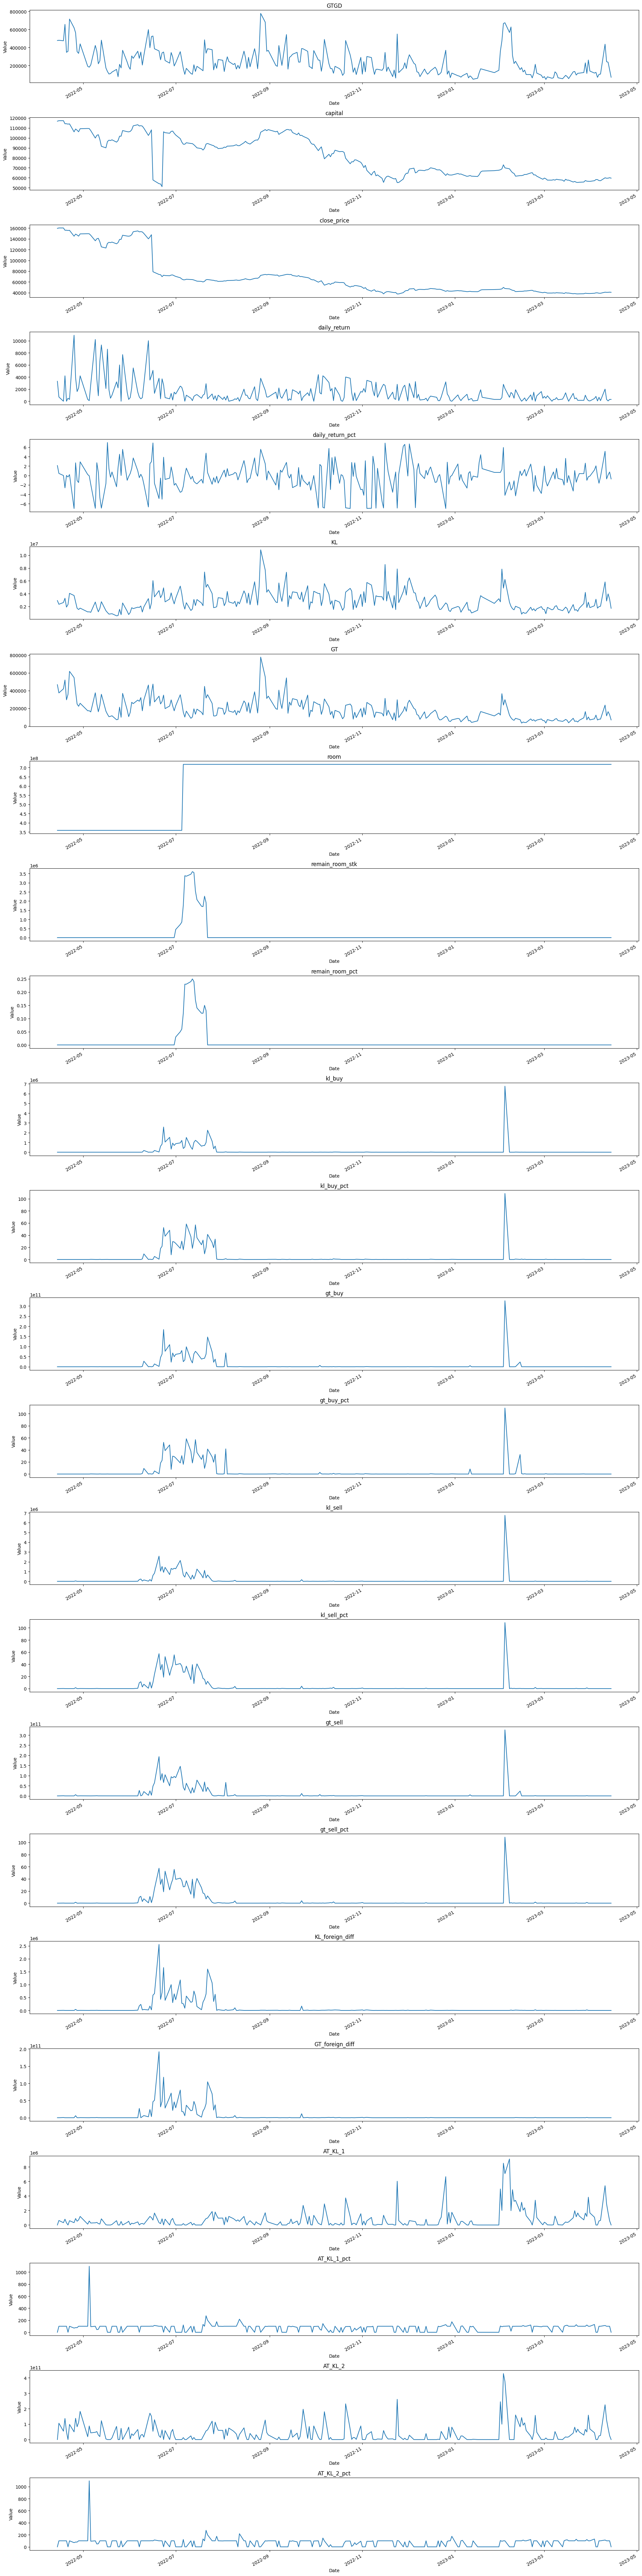

In [36]:
# Create subplots
fig, axes = plt.subplots(nrows=len(df.columns)-1, ncols=1, figsize=(20, 80))

# Plot each column on a separate subplot
for i, col in enumerate(df.columns[1:]):
    df[col].plot(ax=axes[i], title=col)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Value')

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

Correlation

C:\Users\baomc\AppData\Local\Temp\ipykernel_14764\3011984384.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_local.corr(),


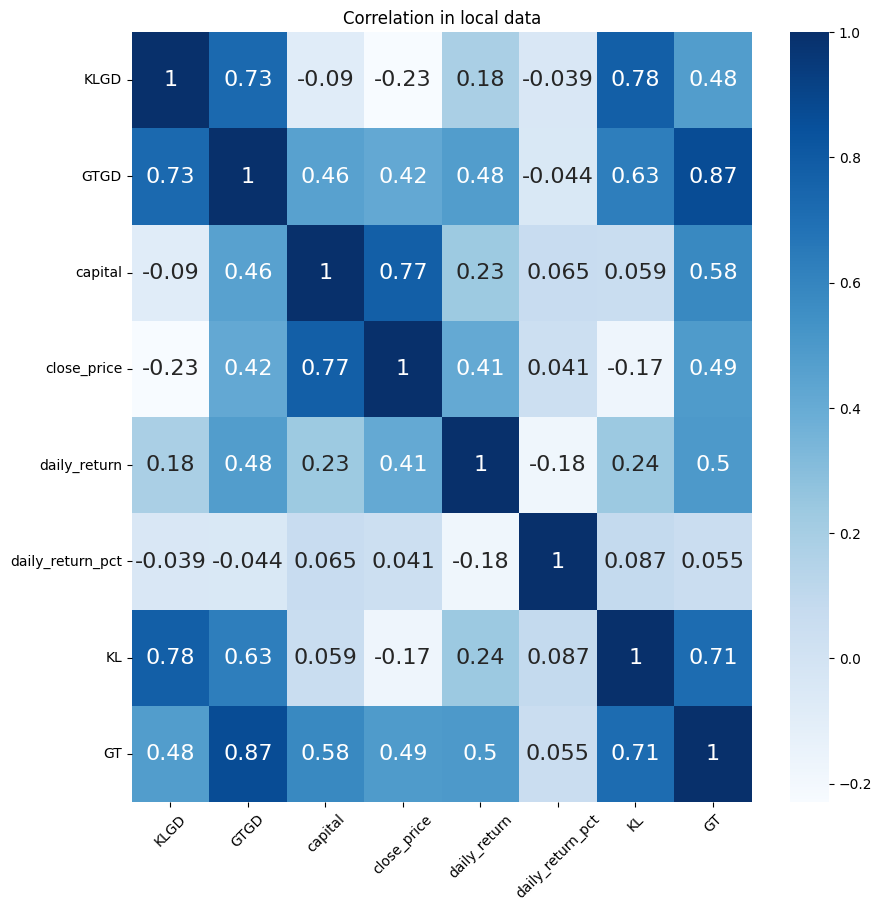

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(df_local.corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)
ax.set_title('Correlation in local data')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

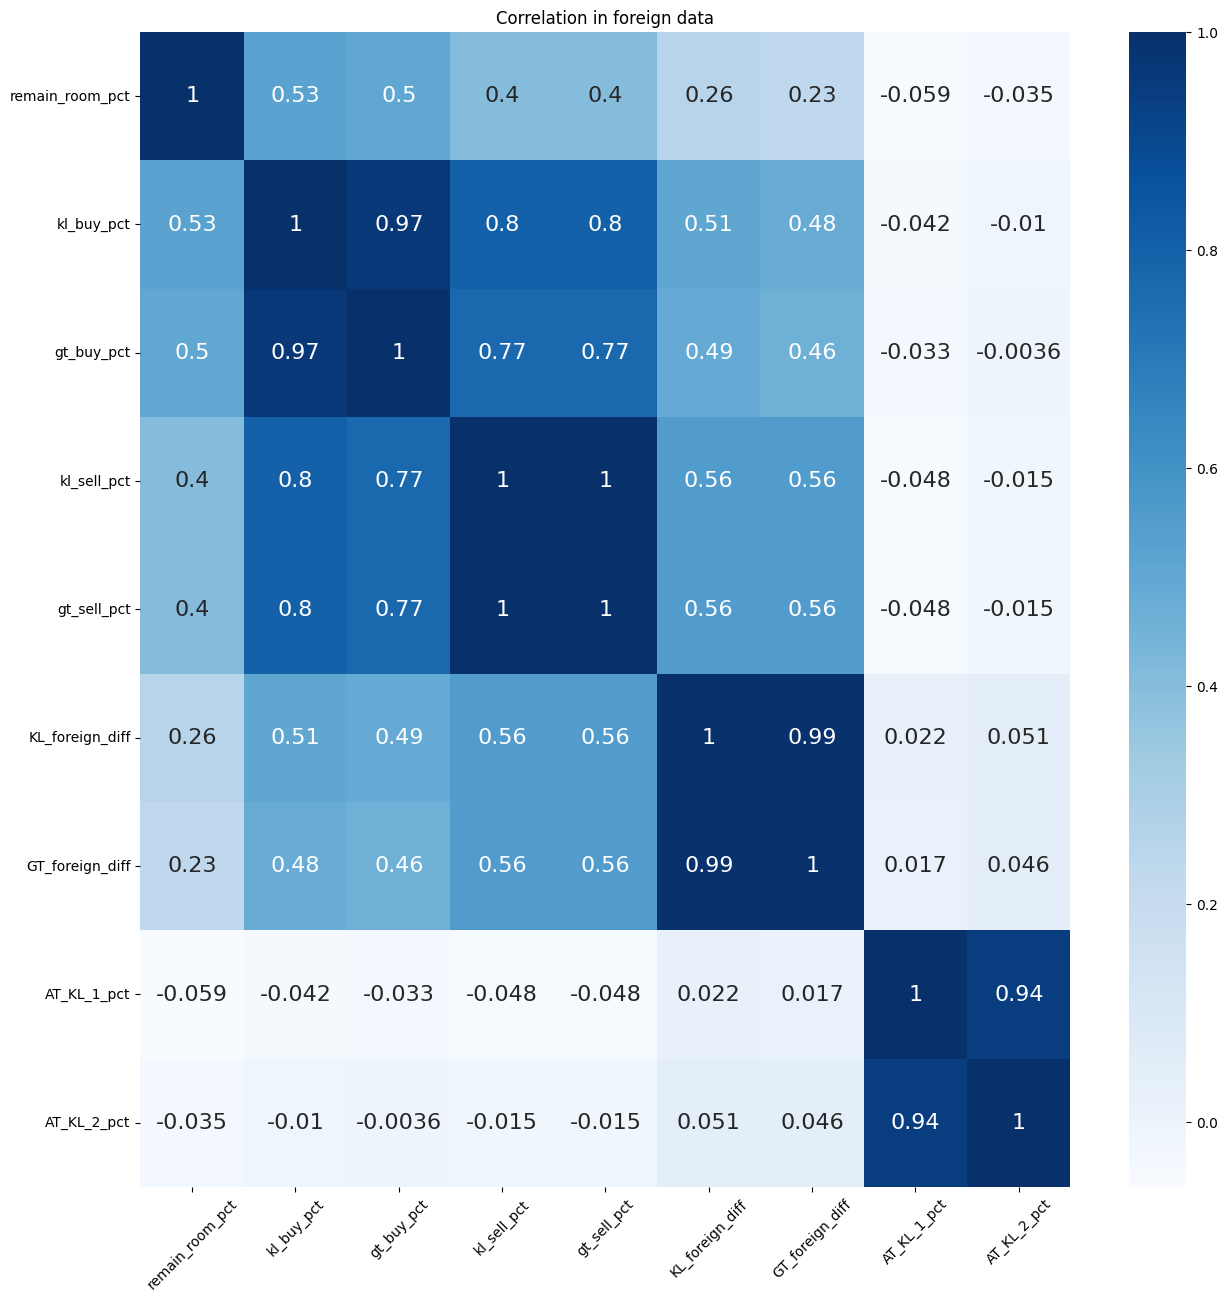

In [38]:
foreign_pct_cols = ['remain_room_pct','kl_buy_pct', 'gt_buy_pct', 'kl_sell_pct', 'gt_sell_pct', 'KL_foreign_diff', 'GT_foreign_diff', 'AT_KL_1_pct', 'AT_KL_2_pct']

fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(df_foreign[foreign_pct_cols].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)
ax.set_title('Correlation in foreign data')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

We can see that all the kl and gt is the same, so we have to remove one of them. I choose to remove the gt

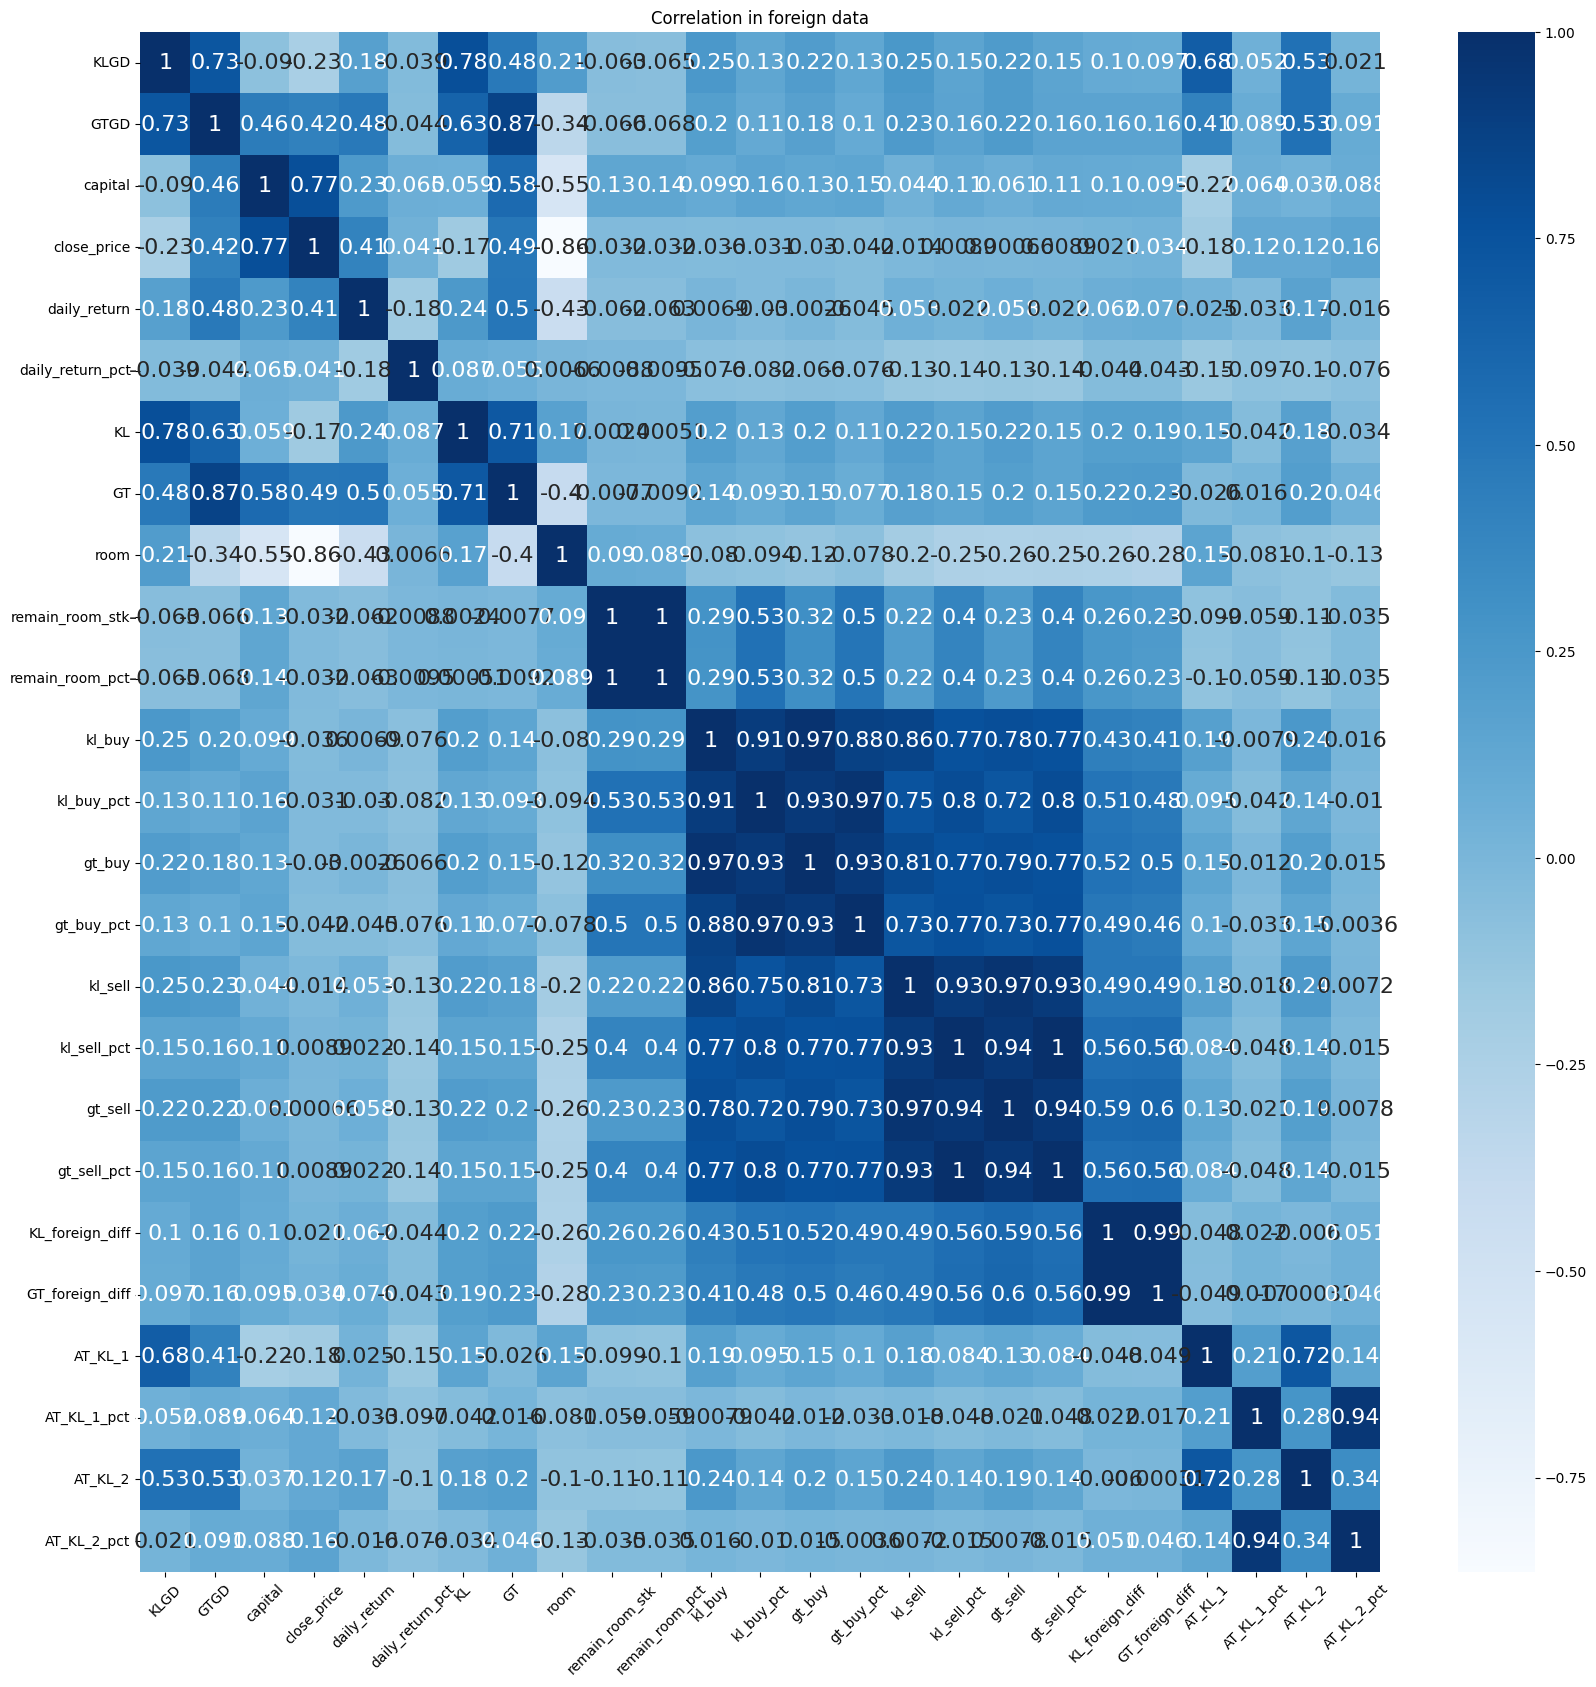

In [39]:
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(df.corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)
ax.set_title('Correlation in foreign data')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

Lets remove some columns

In [40]:
df.columns

Index(['KLGD', 'GTGD', 'capital', 'close_price', 'daily_return',
       'daily_return_pct', 'KL', 'GT', 'room', 'remain_room_stk',
       'remain_room_pct', 'kl_buy', 'kl_buy_pct', 'gt_buy', 'gt_buy_pct',
       'kl_sell', 'kl_sell_pct', 'gt_sell', 'gt_sell_pct', 'KL_foreign_diff',
       'GT_foreign_diff', 'AT_KL_1', 'AT_KL_1_pct', 'AT_KL_2', 'AT_KL_2_pct'],
      dtype='object')

In [41]:
remove_cols = ['gt_buy_pct', 'gt_sell_pct','GT_foreign_diff','AT_KL_2_pct'] #Won't apply standardize 
num_cols = [element for element in foreign_pct_cols if element not in remove_cols]
print (num_cols)

['remain_room_pct', 'kl_buy_pct', 'kl_sell_pct', 'KL_foreign_diff', 'AT_KL_1_pct']


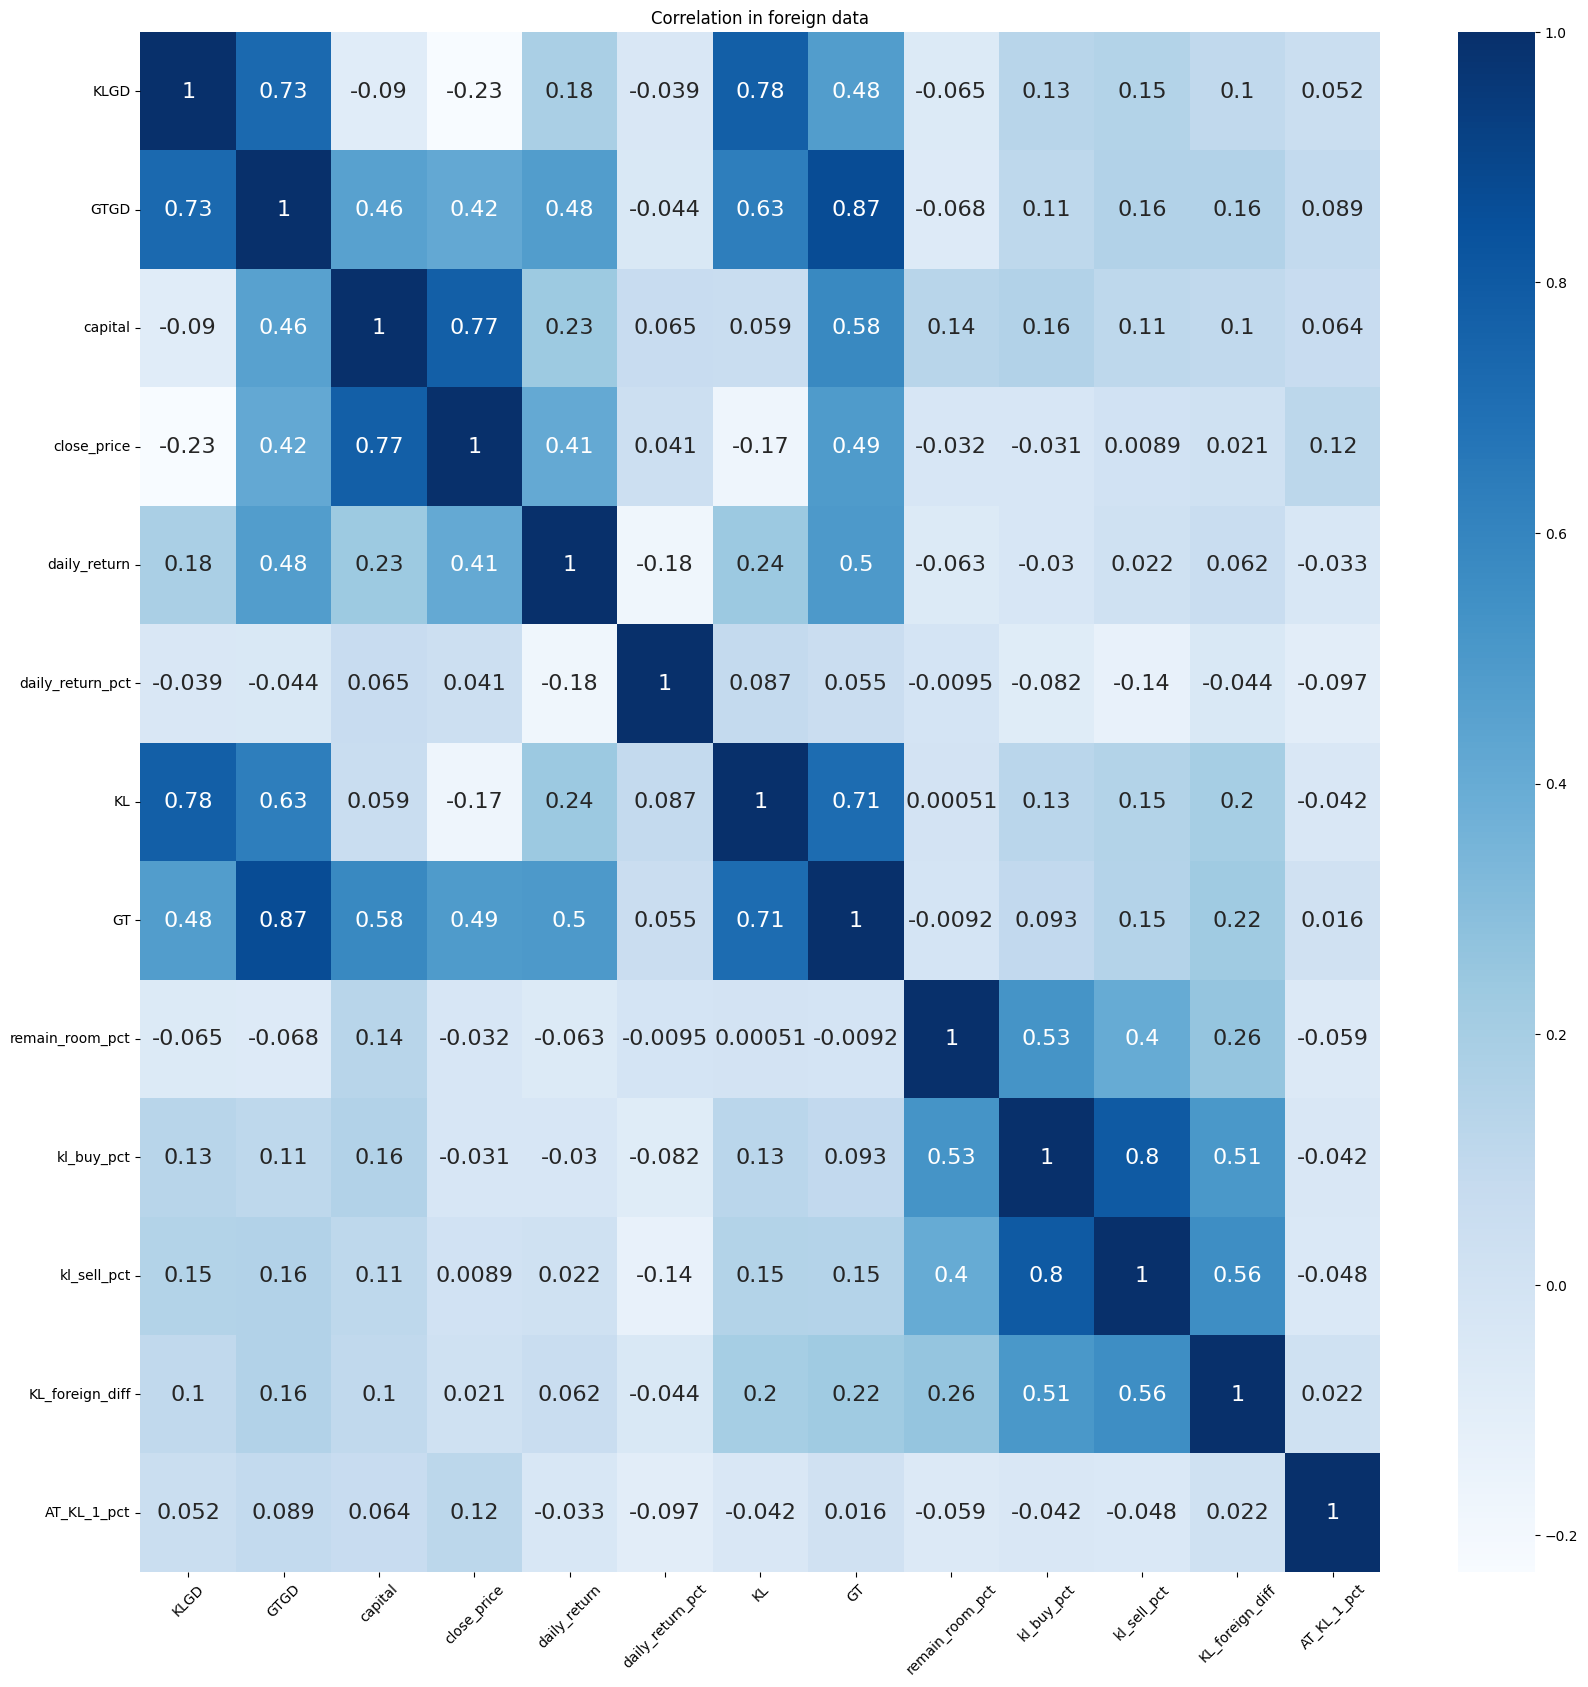

In [42]:
fig, ax = plt.subplots(figsize=(20, 20))

sns.heatmap(df[header_local[1:] + num_cols].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)
ax.set_title('Correlation in foreign data')
ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360);

We can see that the kl_sell_pct is not related to close price

In [43]:
df.room.describe()

count    2.520000e+02
mean     6.362235e+08
std      1.502858e+08
min      3.588057e+08
25%      7.173008e+08
50%      7.173008e+08
75%      7.173008e+08
max      7.174145e+08
Name: room, dtype: float64